# **Editing the Input Data**

We edit the given Data to make it suitable for our Regression Task.
Our Input Data contains the Time (Hour, Day, Month, Year), the Weather (Temperature, Humidity, Sunshine), as well as the Factory Output and the Power Consumption.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# Importing data
df = pd.read_csv('StudentsData2.tab',sep='\t' )
df2 = pd.read_csv('data_OBS_DEU_PT1H_T2M.csv',index_col=False) # Weather data
df3 = pd.read_csv('data_OBS_DEU_PT1H_SD.csv',index_col=False) # Sunshine data
df4 = pd.read_csv('data_OBS_DEU_PT1H_RF.csv',index_col=False) # Humidity data


In [3]:
# Renaming columns
df = df.rename(columns={"DateTime": "Zeitstempel"})
df2 = df2.rename(columns={"Wert": "Temperature"})
df3 = df3.rename(columns={"Wert": "SunshineMinutes"})
df4 = df4.rename(columns={"Wert": "RelativeHumidity"})

In [4]:
# Dropping the first column ; Simmilar to water_potability
df2 = df2.iloc[:, 1:]
df3 = df3.iloc[:, 1:]
df4 = df4.iloc[:, 1:]

In [5]:
# Converting 'Zeitstempel' to datetime
df2['Zeitstempel'] = pd.to_datetime(df2['Zeitstempel'])
df3['Zeitstempel'] = pd.to_datetime(df3['Zeitstempel'])
df4['Zeitstempel'] = pd.to_datetime(df4['Zeitstempel'])

# Changing the date format to "01-Feb-18 00:00"
df2['Zeitstempel'] = df2['Zeitstempel'].dt.strftime('%d-%b-%y %H:%M')
df3['Zeitstempel'] = df3['Zeitstempel'].dt.strftime('%d-%b-%y %H:%M')
df4['Zeitstempel'] = df4['Zeitstempel'].dt.strftime('%d-%b-%y %H:%M')

In [6]:
# Deleting last columns
df2 = df2.iloc[:, 1:3]
df3 = df3.iloc[:, 1:3]
df4 = df4.iloc[:, 1:3]

In [7]:
# Merging Data
df5 = pd.merge(df2,df3, on='Zeitstempel', how='left')

# Replace NaN values in the "SunshineMinutes" column with 0
df5['SunshineMinutes'].fillna(0, inplace=True)

# Merging for merged_df (important dataframe)
df6 = pd.merge(df5,df4, on='Zeitstempel', how='inner')
merged_df = pd.merge(df6,df, on='Zeitstempel', how='inner')

# Adding '-' to prepare a column split
merged_df['Zeitstempel'] = pd.to_datetime(merged_df['Zeitstempel'])
merged_df['Zeitstempel'] = merged_df['Zeitstempel'].dt.strftime('%d-%m-%y-%H:%M')

# Splitting "Zeitstempel" to 'Day', 'Month', 'Year', 'Time'
merged_df[['Day', 'Month', 'Year', 'Time']] = merged_df['Zeitstempel'].str.split('-', expand=True)
# We noticed an inprovement in the models accuracy after splitting the timestamp into Day, Month, Year and Time

# Splitting Time from xx:yy to hours and minutes
merged_df[['Hour' ,'Minutes']] = merged_df['Time'].str.split(':', expand=True)

# Rearranging the column order
merged_df = merged_df[merged_df.columns[[0, 9, 11, 6, 7, 8, 10, 1, 2, 3, 5, 4]].tolist()]

# Dropping columns 0,1,2  (Zeitstempel, Time, Minutes)
merged_df2 = merged_df.iloc[:, 3:]

# Dropping power consumption
merged_df = merged_df.iloc[:, 3:11]

# merged_df2 is our main dataframe
display(merged_df2)

,Day,Month,Year,Hour,Temperature,SunshineMinutes,RelativeHumidity,ManufacturingProcesses,FabPowerConsumption
0,01,02,18,00,6.9,0.0,78,0.838887,0.352852
1,01,02,18,01,6.8,0.0,77,0.839052,0.354843
2,01,02,18,02,6.8,0.0,75,0.839216,0.363601
3,01,02,18,03,6.6,0.0,75,0.839380,0.347556
4,01,02,18,04,4.4,0.0,90,0.839544,0.329847
...,...,...,...,...,...,...,...,...,...
27715,31,03,21,19,19.0,0.0,33,0.998398,0.436132
27716,31,03,21,20,18.1,0.0,33,0.998799,0.431338
27717,31,03,21,21,14.7,0.0,49,0.999199,0.423994
27718,31,03,21,22,12.5,0.0,60,0.999600,0.418269


In [8]:
# Converting specific columns from object to int64 for merged_df
columns_to_convert = ['Day', 'Month', 'Year', 'Hour']

for column in columns_to_convert:
    merged_df[column] = merged_df[column].astype('int64')

# Verify the conversion
#print(merged_df.dtypes)

In [9]:
# Converting columns from object to int64 for merged_df2
columns_to_convert = ['Day', 'Month', 'Year', 'Hour']

for column in columns_to_convert:
    merged_df2[column] = merged_df2[column].astype('int64')

# Verify the conversion
#print(merged_df2.dtypes)

# **Editing the Input Data for Future Predictions**

The Data for future Predictions contains the Time (Hour, Day, Month, Year) and the Weather (Temperature, Humidity, Sunshine).
Later the Factory Output Predictions are also concatenated to this Dataframe.

In [10]:
# Importing weather data
dfpred = pd.read_csv('PredictTemp.csv',index_col=False)
dfpred2 = pd.read_csv('Predicthumidity.csv',index_col=False)
dfpred3 = pd.read_csv('PredictSun.csv',index_col=False)

# Renaming columns
dfpred = dfpred.rename(columns={"Wert": "Temperature"})
dfpred3 = dfpred3.rename(columns={"Wert": "SunshineMinutes"})
dfpred2 = dfpred2.rename(columns={"Wert": "RelativeHumidity"})

# Dropping Produkt_Code
dfpred = dfpred.iloc[:, 1:]
dfpred2 = dfpred2.iloc[:, 1:]
dfpred3 = dfpred3.iloc[:, 1:]

# Converting 'Zeitstempel' to datetime
dfpred['Zeitstempel'] = pd.to_datetime(dfpred['Zeitstempel'])
dfpred2['Zeitstempel'] = pd.to_datetime(dfpred2['Zeitstempel'])
dfpred3['Zeitstempel'] = pd.to_datetime(dfpred3['Zeitstempel'])

# Changing the date format to "01-Feb-18 00:00"
dfpred['Zeitstempel'] = dfpred['Zeitstempel'].dt.strftime('%d-%b-%y %H:%M')
dfpred2['Zeitstempel'] = dfpred2['Zeitstempel'].dt.strftime('%d-%b-%y %H:%M')
dfpred3['Zeitstempel'] = dfpred3['Zeitstempel'].dt.strftime('%d-%b-%y %H:%M')

# Selecting Zeitstempel as well as Temperature, SunshineMinutes and RelativeHumidity to merge later
dfpred = dfpred.iloc[:, 1:3]
dfpred2 = dfpred2.iloc[:, 1:3]
dfpred3 = dfpred3.iloc[:, 1:3]

#display(dfpred)
#display(dfpred2)
#display(dfpred3)

In [11]:
# Merging Data
dfpred4 = pd.merge(dfpred,dfpred2, on='Zeitstempel', how='inner')
merged_dfpred = pd.merge(dfpred4,dfpred3, on='Zeitstempel', how='left')

# Replacing NaN values in the "SunshineMinutes" column with 0
merged_dfpred['SunshineMinutes'].fillna(0, inplace=True)

# Converting the 'Zeitstempel' column in the DataFrame merged_dfpred to a datetime data type
merged_dfpred['Zeitstempel'] = pd.to_datetime(merged_dfpred['Zeitstempel'])

# Converting to the string format: day-month-year-hour:minute
merged_dfpred['Zeitstempel'] = merged_dfpred['Zeitstempel'].dt.strftime('%d-%m-%y-%H:%M')

# Splitting the 'Zeitstempel' column into four separate columns ('Day', 'Month', 'Year', 'Time') based on the '-' delimiter
merged_dfpred[['Day', 'Month', 'Year', 'Time']] = merged_dfpred['Zeitstempel'].str.split('-', expand=True)

# Splitting the 'Time' column into two separate columns ('Hour', 'Minutes') based on the ':' delimiter
merged_dfpred[['Hour' ,'Minutes']] = merged_dfpred['Time'].str.split(':', expand=True)

# Rearranging column order
merged_dfpred = merged_dfpred[merged_dfpred.columns[[0, 7, 9, 4, 5, 6, 8, 1, 3, 2]].tolist()]

# Dropping Zeitstempel, Time, Minutes
merged_dfpred = merged_dfpred.iloc[:, 3:]

# This is our Input Dataframe for the future Predictions
display(merged_dfpred)

,Day,Month,Year,Hour,Temperature,SunshineMinutes,RelativeHumidity
0,01,04,21,00,10.9,0.0,65
1,01,04,21,01,10.3,0.0,65
2,01,04,21,02,10.7,0.0,61
3,01,04,21,03,9.7,0.0,64
4,01,04,21,04,9.5,0.0,64
...,...,...,...,...,...,...,...
67,03,04,21,19,3.8,0.0,69
68,03,04,21,20,3.6,0.0,72
69,03,04,21,21,3.6,0.0,67
70,03,04,21,22,2.3,0.0,72


# **Creating the Regression Model (Random Forest Regression)**

We split the Regression into two Parts. First we extract the Input Data and split it into Train, Validation and Test Sets. Afterwards we define and train the Regression.

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Extracting past features for factory output and power consumption
past_features_output = merged_df[['Day', 'Month', 'Year', 'Hour', 'Temperature', 'SunshineMinutes', 'RelativeHumidity']]
past_features_power = merged_df2[['Day', 'Month', 'Year', 'Hour', 'Temperature', 'SunshineMinutes', 'RelativeHumidity','ManufacturingProcesses']]

# Extracting Targets
past_power_consumption = merged_df2['FabPowerConsumption']
past_factory_output = merged_df2['ManufacturingProcesses']

# Splitting data for factory output
X_train_factory, X_temp_factory, y_train_factory, y_temp_factory = train_test_split(
    past_features_output, past_factory_output, test_size=0.2, random_state=42)

X_val_factory, X_test_factory, y_val_factory, y_test_factory = train_test_split(
    X_temp_factory, y_temp_factory, test_size=0.5, random_state=42)

# Splitting data for power consumption
X_train_power, X_temp_power, y_train_power, y_temp_power = train_test_split(
    past_features_power, past_power_consumption, test_size=0.2, random_state=42)

X_val_power, X_test_power, y_val_power, y_test_power = train_test_split(
    X_temp_power, y_temp_power, test_size=0.5, random_state=42)

# Define the Random Forest Regressor models
rf_factory_output = RandomForestRegressor(n_estimators=100, random_state=42)
rf_power_consumption = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the models for factory output and power consumption
rf_factory_output.fit(X_train_factory, y_train_factory)
rf_power_consumption.fit(X_train_power, y_train_power);



Here we predict the Factory Output first to use the predictions to predict the Power Consumption values. Then we evaluate the performance and display the results.  

In [16]:
# Extracting future features (for prediction)
future_features = merged_dfpred.copy()

# Predicting factory output for the next three days
output_predictions_next_three_days = rf_factory_output.predict(future_features)

# Concatenating output predictions with future features
combined_future_features = pd.concat([future_features.reset_index(drop=True), pd.Series(output_predictions_next_three_days, name='ManufacturingProcesses')], axis=1)

# Predicting Power Consumption for the next three days
power_predictions_next_three_days = rf_power_consumption.predict(combined_future_features)

# Creating a DataFrame for the predictions
predictions_next_three_days = pd.DataFrame({
    'Factory Output Predictions': output_predictions_next_three_days,
    'Power Consumption Predictions': power_predictions_next_three_days
})

# Evaluating the models on the test set
mse_power = mean_squared_error(y_test_power, rf_power_consumption.predict(X_test_power))
mse_output = mean_squared_error(y_test_factory, rf_factory_output.predict(X_test_factory))
r2_score_power = r2_score(y_test_power, rf_power_consumption.predict(X_test_power))
r2_score_output = r2_score(y_test_factory, rf_factory_output.predict(X_test_factory))

print("Mean Squared Error for Power Consumption on Test Set:", mse_power)
print("Mean Squared Error for Factory Output on Test Set:", mse_output)
print("R2 Score for Power Consumption on Test Set:", r2_score_power)
print("R2 Score for Factory Output on Test Set:", r2_score_output)

# Displaying the DataFrame
display(predictions_next_three_days)

Mean Squared Error for Power Consumption on Test Set: 0.0007007102592015955
Mean Squared Error for Factory Output on Test Set: 3.428781658402992e-05
R2 Score for Power Consumption on Test Set: 0.9732105105134488
R2 Score for Factory Output on Test Set: 0.9989989335833827


,Factory Output Predictions,Power Consumption Predictions
0,0.897620,0.383308
1,0.897645,0.378636
2,0.897620,0.384418
3,0.897645,0.371587
4,0.897645,0.368358
...,...,...
67,0.867995,0.320331
68,0.867637,0.318788
69,0.868378,0.320962
70,0.868500,0.319513


At first we used a Linear Regression Model, but we could quickly tell that the model was not suitable for the given task. The predictions were nonsensical and very far away from the data we had from the last hours before our prediction. These last datapoints can be seen in one of the plots at the end. There were huge jumps in factory output and power consumption, even values above 1, which would be impossible. Thats when we realized that there was no linear correlation in our data and we had to switch to a better model.

We chose a random Forrest Regression as it has several key advantages for our Prediction Task.

1. High Predictive Accuracy
2. Can capture complex, non-linear relationships in the Data
3. Robust to Overfitting

We chose the Mean Squared Error, Root Mean Squared Error and R2 Score to evaluate the performance of our Regression Model.
The Evaluation shows that our Model can very accurately interpret the data. An R2 Score of 99,89% and 97,3% respectively show that the predictions should capture almost all details of the underlying data.

# **Creating the Neural Network**

Running the Neural Network again, can potentially change the Predictions to a point where our written observations dont match the Plot below.


As the Power Consumption is based on the Factory Output, we first had to predict the Factory Output for the next three days. Therefore we had to establish two neural Networks. One to predict the Factory Output and then using those predictions to predict the Power Consumption with the second model.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Nadam


# Extracting features, factory output, and power consumption
features_factory_output = merged_df2[['Day', 'Month', 'Year', 'Hour', 'Temperature', 'SunshineMinutes', 'RelativeHumidity']]
features_power_consumption = merged_df2[['Day', 'Month', 'Year', 'Hour', 'Temperature', 'SunshineMinutes', 'RelativeHumidity','ManufacturingProcesses']]
power_consumption = merged_df2['FabPowerConsumption']
factory_output = merged_df2['ManufacturingProcesses']

# Splitting the data into training and testing sets for factory output
X_train_factory, X_test_factory, y_factory_train, y_factory_test = train_test_split(
    features_factory_output, factory_output, test_size=0.2, random_state=42)

# Scaling factory output features
scaler_factory = MinMaxScaler()
X_train_factory_scaled = scaler_factory.fit_transform(X_train_factory)
X_test_factory_scaled = scaler_factory.transform(X_test_factory)

# The number of neurons as well as the learning rate in our models were determined as the best possible values through a grid search, as indicated by the grid search conducted after the neural network
# The activation functions relu as well as sigmoid and the optimizer nadam we are using in the following models were determined through torough testing a large number of different combinations outside of the grid search and comparing the results
# Model for predicting factory output
model_factory_output = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_factory_scaled.shape[1],)),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compiling the model for factory output prediction
learning_rate_factory = 0.002
optimizer_factory = Nadam(learning_rate=learning_rate_factory)
model_factory_output.compile(optimizer=optimizer_factory, loss='mean_squared_error')

# Training the model for predicting factory output
model_factory_output.fit(X_train_factory_scaled, y_factory_train, epochs=100, batch_size=16, validation_split=0.2)

# Predicting factory output on the test set
factory_output_predictions = model_factory_output.predict(X_test_factory_scaled)

#--------------------------------------------------------------------------
# Neural Network for Power Consumption

# Splitting the data into training and testing sets for power consumption
X_train_power, X_test_power, y_power_train, y_power_test = train_test_split(
    features_power_consumption, power_consumption, test_size=0.2, random_state=42)

# We did not use the Grid Search Results for this model, because the predictions were suboptimal
# Model for predicting power consumption
model_power_consumption = Sequential([
    Dense(128, activation='relu', input_shape=(8,)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compiling the model for power consumption prediction
learning_rate_power = 0.001
optimizer_power = Nadam(learning_rate=learning_rate_power)
model_power_consumption.compile(optimizer=optimizer_power, loss='mean_squared_error')

# Training the model for predicting power consumption
model_power_consumption.fit(X_train_power, y_power_train, epochs=100, batch_size=16, validation_split=0.2)

# Predicting power consumption on the test set
power_consumption_predictions = model_power_consumption.predict(X_test_power)


(5544, 7)

Epoch 1/100
1109/1109 [==============================] - 6s 4ms/step - loss: 0.0091 - val_loss: 0.0079
Epoch 2/100
1109/1109 [==============================] - 3s 3ms/step - loss: 0.0057 - val_loss: 0.0053
Epoch 3/100
1109/1109 [==============================] - 4s 3ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 4/100
1109/1109 [==============================] - 5s 4ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 5/100
1109/1109 [==============================] - 3s 3ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 6/100
1109/1109 [==============================] - 3s 3ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 7/100
1109/1109 [==============================] - 4s 3ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 8/100
1109/1109 [==============================] - 5s 4ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 9/100
1109/1109 [==============================] - 3s 3ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 10/100
1109/1109 [==============================] - 3s 3ms/step - l

Below we predict the new Factory Output. Establishing a new Dataframe for the Power Consumption Prediction and then displaying our results.

In [ ]:
# Extracting future features (for Prediction)
future_features = merged_dfpred

# Standardizing the features
future_features_scaled = scaler_factory.transform(future_features)

# Predicting Factory Output
new_factory_output_predictions = model_factory_output.predict(future_features_scaled)

# Combining Features for Power Consumption Prediction
new_combined_features_power = pd.DataFrame({
    'Day': future_features['Day'],
    'Month': future_features['Month'],
    'Year': future_features['Year'],
    'Hour': future_features['Hour'],
    'Temperature': future_features['Temperature'],
    'SunshineMinutes': future_features['SunshineMinutes'],
    'RelativeHumidity': future_features['RelativeHumidity'],
    'Predicted_Factory_Output': new_factory_output_predictions.flatten()
})
new_combined_features_power_tensor = tf.constant(new_combined_features_power.values, dtype=tf.float32)

# Predicting Power Consumption
new_power_consumption_predictions = model_power_consumption.predict(new_combined_features_power_tensor)

# Concatenating the Predictions
predictions_array = np.column_stack((new_power_consumption_predictions, new_factory_output_predictions))

# Creating a DataFrame from the concatenated array
predictions_df_nn = pd.DataFrame(predictions_array, columns=['Power Consumption Predictions', 'Factory Output Predictions'])

# Displaying the DataFrame
display(predictions_df_nn)

3/3 [==============================] - 0s 4ms/step


,Power Consumption Predictions,Factory Output Predictions
0,0.383547,0.892614
1,0.370779,0.892183
2,0.375678,0.891188
3,0.370481,0.891171
4,0.369494,0.890669
...,...,...
67,0.330586,0.913812
68,0.334305,0.914157
69,0.330943,0.914854
70,0.324643,0.915207


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculating MSE, RMSE and R2 Score for Factory Output
mse_factory_output = mean_squared_error(y_factory_test, factory_output_predictions)
rmse_factory_output = np.sqrt(mse_factory_output)
r2_factory_output = r2_score(y_factory_test, factory_output_predictions)

print("MSE for Factory Output", mse_factory_output)
print("RMSE for Factory Output:", rmse_factory_output)
print("R2 Score for Factory Output:", r2_factory_output)

# Calculating MSE, RMSE and R2 Score for Power Consumption
mse_power_consumption = mean_squared_error(y_power_test, power_consumption_predictions)
rmse_power_consumption = np.sqrt(mse_power_consumption)
r2_power_consumption = r2_score(y_power_test, power_consumption_predictions)

print("MSE for Power Consumption", mse_power_consumption)
print("RMSE for Power Consumption:", rmse_power_consumption)
print("R2 Score for Power Consumption:", r2_power_consumption)

MSE for Factory Output 0.00038482187361803304
RMSE for Factory Output: 0.0196168772646931
R2 Score for Factory Output: 0.9888939769435837
MSE for Power Consumption 0.0012548980485401766
RMSE for Power Consumption: 0.035424540202240826
R2 Score for Power Consumption: 0.9523366263808888


We chose the Mean Squared Error, Root Mean Squared Error and R2 Score to evaluate the performance of our Neural Network.
We are especially happy with the R2 Score, as our models can predict 98,8% and 95,2% of the variance in the given test set.

A previous model had an MSE in the range of 4e-06 and 8e-07, but the model seemed to also capture random noise in the data and the output predictions were subpar.
In total we created seven or eight different neural networks, using different libraries and ways of constructing the model itself until we were happy with the result as none of us has ever worked with neural networks before.

Comparing the Evaluation of the Regression Model with the Neural Network shows that both Models can very accurately interpret the underlying data and are able to predict future data with solid accuracy.  

**Installing old TensorFlow Version**

In [ ]:
!pip install tensorflow==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 35.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.2.0
    Uninstalling google-auth-oauthlib-1.2.0:
      Successfully un

# **Grid Search**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Nadam

# Extracting features and factory output target
features_factory_output = merged_df2[['Day', 'Month', 'Year', 'Hour', 'Temperature', 'SunshineMinutes', 'RelativeHumidity']]
factory_output = merged_df2['ManufacturingProcesses']

# Splitting the data into training and testing sets
X_train_factory, X_test_factory, y_factory_train, y_factory_test = train_test_split(
    features_factory_output, factory_output, test_size=0.2, random_state=42)

# Scaling features
scaler_factory = MinMaxScaler()
X_train_factory_scaled = scaler_factory.fit_transform(X_train_factory)
X_test_factory_scaled = scaler_factory.transform(X_test_factory)

# Model for predicting factory output with different hidden units
def create_model(hidden_units_layer1=128, hidden_units_layer2=64, learning_rate=0.001):
    model = Sequential([
        Dense(hidden_units_layer1, activation='relu', input_shape=(X_train_factory_scaled.shape[1],)),
        Dense(hidden_units_layer2, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Defining the hyperparameter grid for Grid Search
param_grid = {
    'hidden_units_layer1': [64, 128, 256],
    'hidden_units_layer2': [32, 64, 128],
    'learning_rate': [0.001, 0.01, 0.002],
    'batch_size': [16, 32, 64]
}

# Creating the KerasRegressor
keras_regressor = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_model, epochs=50, verbose=0)

# Using GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=keras_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=2)
grid_result = grid_search.fit(X_train_factory_scaled, y_factory_train)

# Displaying the best parameters and corresponding MSE
print("Best Parameters: ", grid_result.best_params_)
print("Best MSE: ", -grid_result.best_score_)


<ipython-input-94-683b9a8bb6af>:49: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_regressor = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_model, epochs=50, verbose=0)


Best Parameters:  {'batch_size': 16, 'hidden_units_layer1': 256, 'hidden_units_layer2': 128, 'learning_rate': 0.002}
Best MSE:  0.0007960363001261216


As running a Grid Search is very computationally intense and the improvements were very marginal above our testing of different parameters while constructing the model itself, we refrained from constructing a second Grid Search for the Power Consumption Model.  

# **Comparing the Regression to the Neural Network**

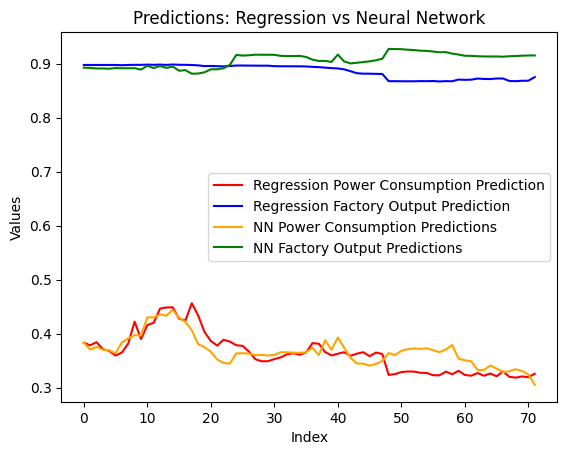

In [ ]:
import matplotlib.pyplot as plt

# Plotting the Regression predictions
plt.plot(power_predictions_next_three_days, label='Regression Power Consumption Prediction', color='red')
plt.plot(output_predictions_next_three_days, label='Regression Factory Output Prediction', color='blue')

# Plotting the NN predictions
plt.plot(new_power_consumption_predictions, label='NN Power Consumption Predictions', color='orange')
plt.plot(new_factory_output_predictions, label='NN Factory Output Predictions', color='green')

# Adding labels and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Predictions: Regression vs Neural Network')
plt.legend()

# Printing the plot
plt.show()

Plotting the Predictions from the Regression Model and the Neural Network show a striking simmilarity between the two. The Power Consumption Curves are very simmilar and follow the same pattern. The Neural Network has slightly more volatile Factory Output Predictions but are overall not far apart. Interestingly the Neural Network predicts the exact opposite trend from the Regression Model for the Factory Output on the third day. Given that both Models predict a simmilar Power Consumption Curve we are certain that both models interpret the underlying data in a simmilar way. Therefore we are not sure what is causing this mirroring effect.

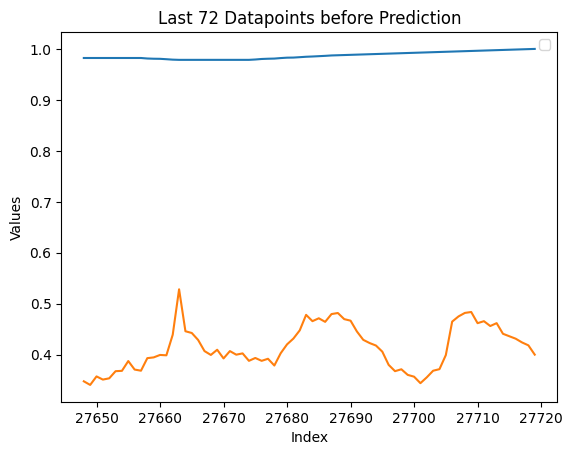

In [17]:
import matplotlib.pyplot as plt

# Extracting the Factory Output and Power Consumption from the last 72 hrs before the Prediction
last_72_datapoints_output = merged_df2['ManufacturingProcesses'].iloc[-72:]
last_72_datapoints_power = merged_df2['FabPowerConsumption'].iloc[-72:]

# Plotting
plt.plot(last_72_datapoints_output)
plt.plot(last_72_datapoints_power)
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Last 72 Datapoints before Prediction')
plt.show()


These are the last 72 hours before we begin our Prediction. Our Models both predict a drop in Factory Output of around 10% directly after the last datapoint. Given that both models predict nearly the same value, we are not concerned that this 10% drop is unreasonable. Given that we dont know what these values represent in reality.
Both our models predict less Power Consumption and also less volatility. We predict no Power Consumption Spikes for the next three days, unlike the Spike that can be seen in the Plot above.

# **Plots that were used to identify possible Causations in the Data**

We have left over all relevant plots that we found useful.
We have noticed that the Power Consumption and Temperature are very strongly correlated. The Temperature is plotted for the prediction period and the last 72 datapoints. In both we can clearly observe that the Power Consumption and temperature graphs follow the same pattern. This gives us extra confidence that our predictions are accurate.

We have also plotted the Power Consumption and Factory Output from the provided data to show that a large difference between the Power Consumption and Factory Output is not unusual. It is also shown in the plot for the last 72 datapoints.

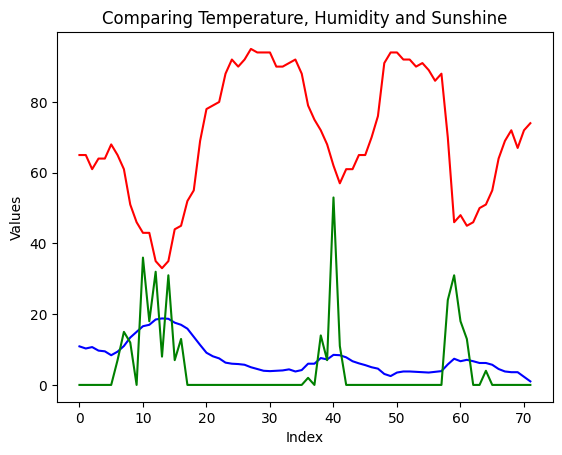

In [19]:
import matplotlib.pyplot as plt

temperatur_pred = merged_dfpred['Temperature']
humidity_pred = merged_dfpred['RelativeHumidity']
sun_pred = merged_dfpred['SunshineMinutes']

plt.plot(temperatur_pred, color='blue')
plt.plot(humidity_pred, color='red')
plt.plot(sun_pred, color='green')

# Adding labels and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Comparing Temperature, Humidity and Sunshine')

# Show the plot
plt.show()

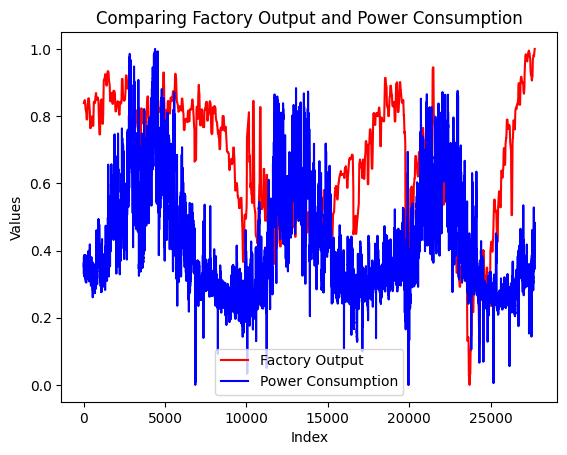

In [20]:
import matplotlib.pyplot as plt

# Plotting the Factory Output and Power Consumption
plt.plot(merged_df2['ManufacturingProcesses'], label='Factory Output', color='red')
plt.plot(merged_df2['FabPowerConsumption'], label='Power Consumption', color='blue')


# Adding labels and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Comparing Factory Output and Power Consumption')
plt.legend()

# Show the plot
plt.show()

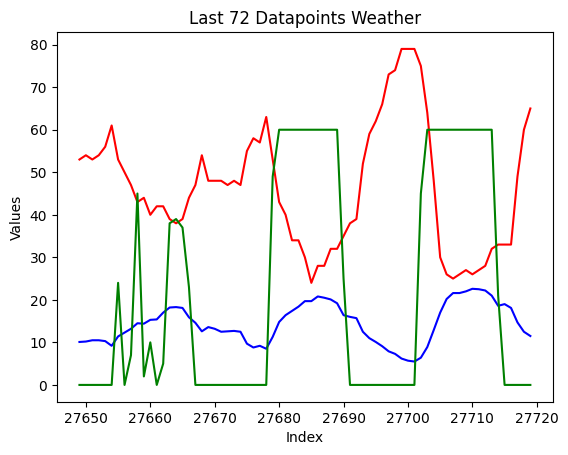

In [ ]:
import matplotlib.pyplot as plt

temperatur = merged_df2['Temperature'].iloc[27649:27720]
humidity = merged_df2['RelativeHumidity'].iloc[27649:27720]
sun = merged_df2['SunshineMinutes'].iloc[27649:27720]

plt.plot(temperatur, color='blue')
plt.plot(humidity, color='red')
plt.plot(sun, color='green')


plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Last 72 Datapoints Weather')
plt.show()